In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import torch
import random

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from Weighted_VP_model import *
sys.path.append(os.path.abspath('../Weighted_VP_model'))

# Now you can import net.py from vpnet
from vpnet import *
from vpnet.vp_functions import *


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
notebook_dir = os.getcwd()

In [4]:
csv_path = os.path.join(notebook_dir, '..', 'data', 'raw_data.csv')
csv_path = os.path.abspath(csv_path)
raw_data = pd.read_csv(csv_path)
raw_data.info()
raw_data[:10]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071475 entries, 0 to 8071474
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   raw_ts         float64
 1   raw_amplitude  float64
dtypes: float64(2)
memory usage: 123.2 MB


,raw_ts,raw_amplitude
0,2000.000049,1.522938
1,2000.000149,1.458149
2,2000.000249,1.004952
3,2000.000349,-0.116204
4,2000.000449,-0.809816
5,2000.000549,-0.682868
6,2000.000649,-0.449690
7,2000.000749,-0.259925
8,2000.000849,0.224188
9,2000.000949,0.443881


In [5]:
csv_path = os.path.join(notebook_dir, '..', 'data', 'spike_timestamps.csv')
csv_path = os.path.abspath(csv_path)
ground_truth_spikes = pd.read_csv(csv_path)
ground_truth_spikes.info()
ground_truth_spikes[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   spike_idx  536 non-null    int64  
 1   spike_ts   536 non-null    float64
 2   track      536 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 12.7+ KB


,spike_idx,spike_ts,track
0,0,2000.062149,Track3
1,1,2000.073049,Track4
2,2,2004.062249,Track3
3,3,2004.073149,Track4
4,4,2008.062349,Track3
5,5,2008.073049,Track4
6,6,2012.062349,Track3
7,7,2012.073149,Track4
8,8,2016.059667,Track3
9,9,2016.070467,Track4


In [6]:
csv_path = os.path.join(notebook_dir, '..', 'data', 'stimulation_timestamps.csv')
csv_path = os.path.abspath(csv_path)
stimulation = pd.read_csv(csv_path)
stimulation.info()
stimulation[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stimulation_idx  267 non-null    int64  
 1   stimulation_ts   267 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.3 KB


,stimulation_idx,stimulation_ts
0,0,2003.838249
1,1,2007.838249
2,2,2011.838249
3,3,2015.835667
4,4,2016.085667
5,5,2016.335667
6,6,2016.585667
7,7,2019.835550
8,8,2023.835550
9,9,2027.835550


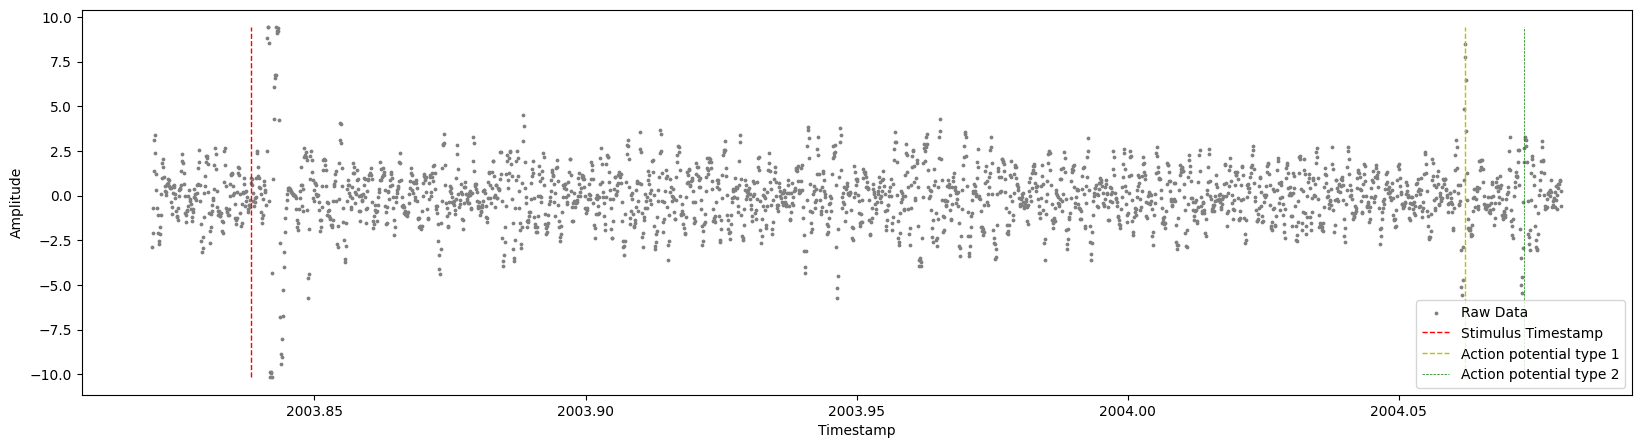

In [ ]:


def plot_data(df_first_part):
    min_ts = df_first_part['raw_ts'].min()
    max_ts = df_first_part['raw_ts'].max()

    df_timestamps_in_range = stimulation[
        (stimulation['stimulation_ts'] >= min_ts) & (stimulation['stimulation_ts'] <= max_ts)
    ]

    df_timestamps_in_range_gt = ground_truth_spikes[
        (ground_truth_spikes['spike_ts'] >= min_ts) & (ground_truth_spikes['spike_ts'] <= max_ts)
    ]

    plt.figure(figsize=(20, 5))
    plt.scatter(df_first_part['raw_ts'], df_first_part['raw_amplitude'], label='Raw Data', color='gray', s=3)


    plt.vlines(df_timestamps_in_range['stimulation_ts'], 
            ymin=df_first_part['raw_amplitude'].min(), 
            ymax=df_first_part['raw_amplitude'].max(), 
            color='r', linestyle='--', label='Stimulus Timestamp', linewidth=1)

    df_value1 = df_timestamps_in_range_gt[df_timestamps_in_range_gt['track'] == 'Track3']
    df_value2 = df_timestamps_in_range_gt[df_timestamps_in_range_gt['track'] == 'Track4']


    plt.vlines(df_value1['spike_ts'], 
            ymin=df_first_part['raw_amplitude'].min(), 
            ymax=df_first_part['raw_amplitude'].max(), 
            color='y', linestyle='--', label='Action potential type 1', linewidth=1)

    plt.vlines(df_value2['spike_ts'], 
            ymin=df_first_part['raw_amplitude'].min(), 
            ymax=df_first_part['raw_amplitude'].max(), 
            color='g', linestyle='--', label='Action potential type 2', linewidth=0.5)

    plt.xlabel('Timestamp')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.show()

df_first_part = raw_data.iloc[38200:40800]
plot_data(df_first_part)

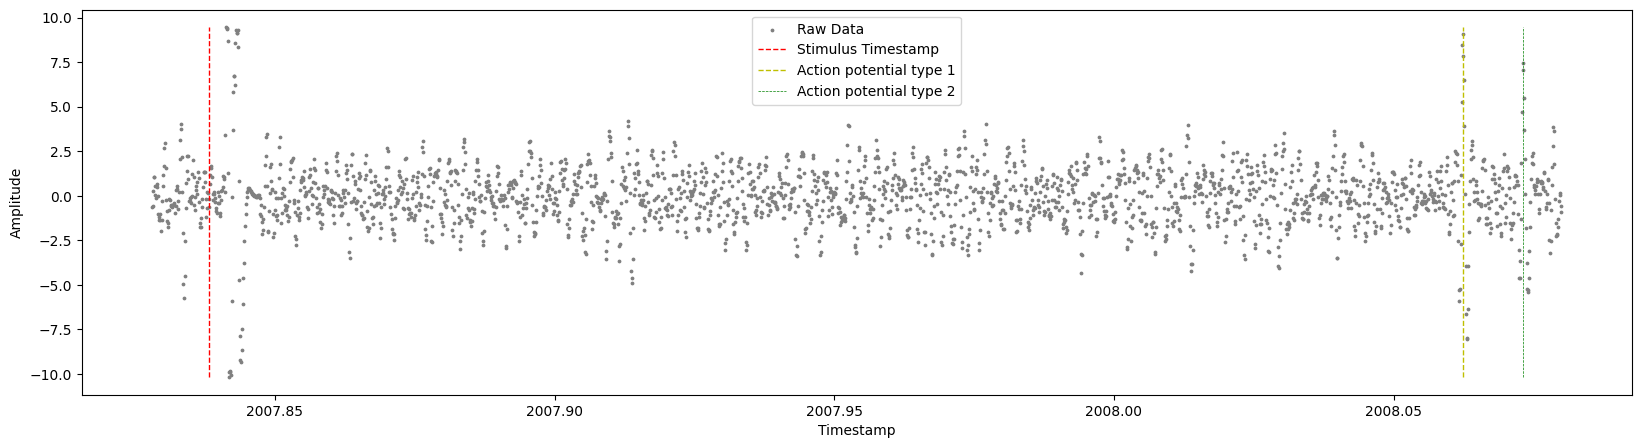

In [42]:
df_first_part = raw_data.iloc[78280:80800]
plot_data(df_first_part)

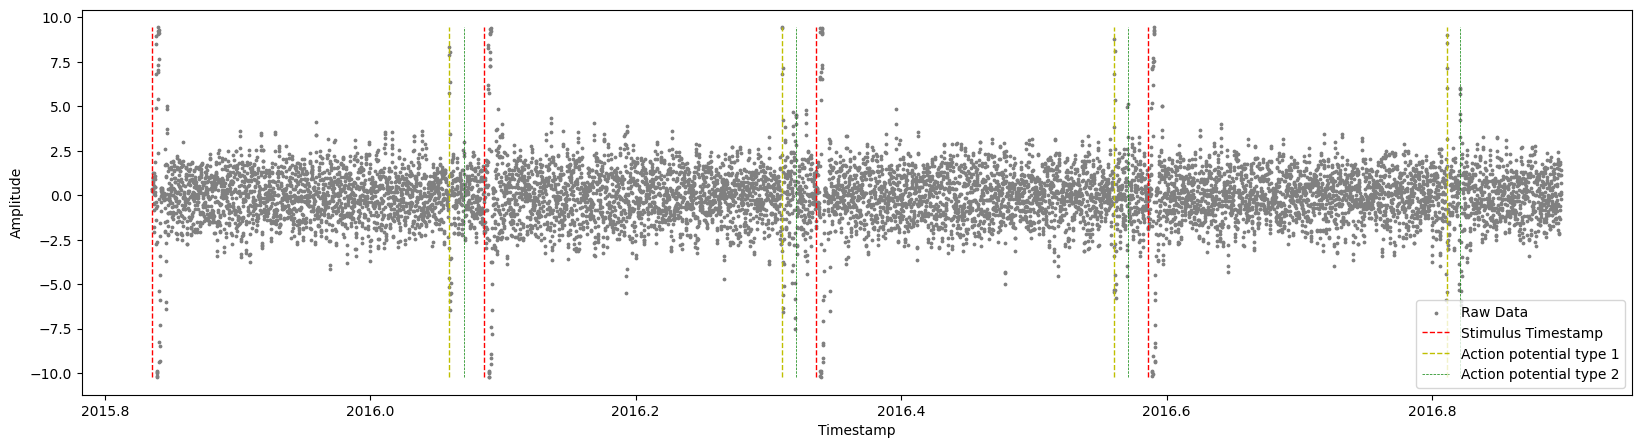

In [47]:
df_first_part = raw_data.iloc[157382:168000]
plot_data(df_first_part)

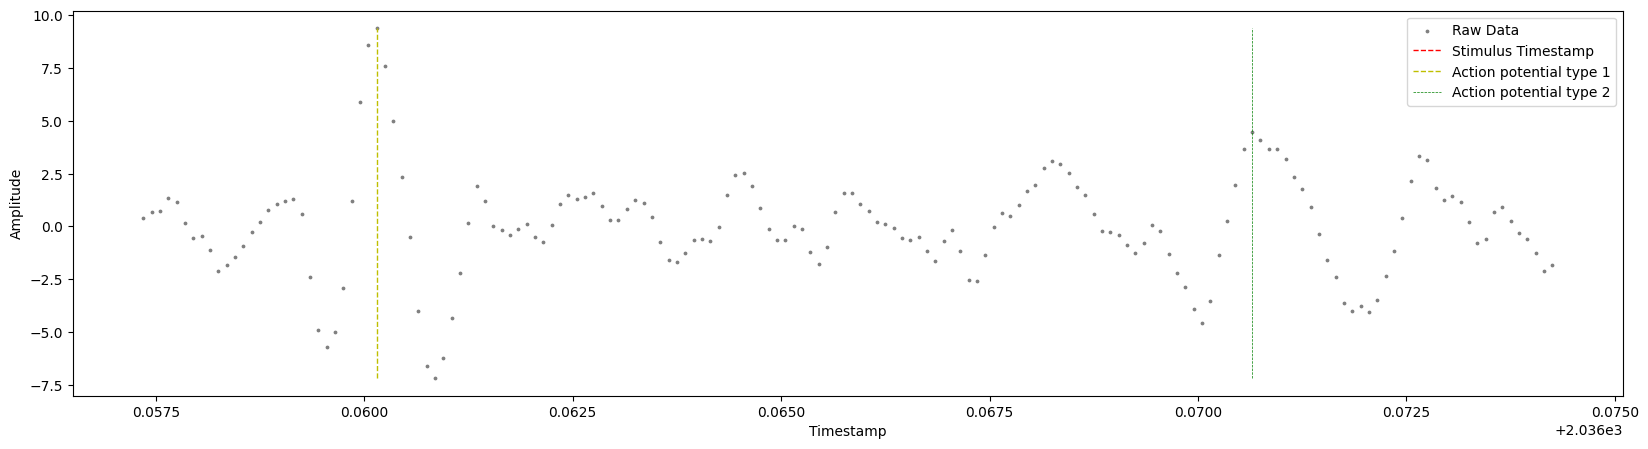

In [49]:
df_first_part = raw_data.iloc[358600:358770]
plot_data(df_first_part)

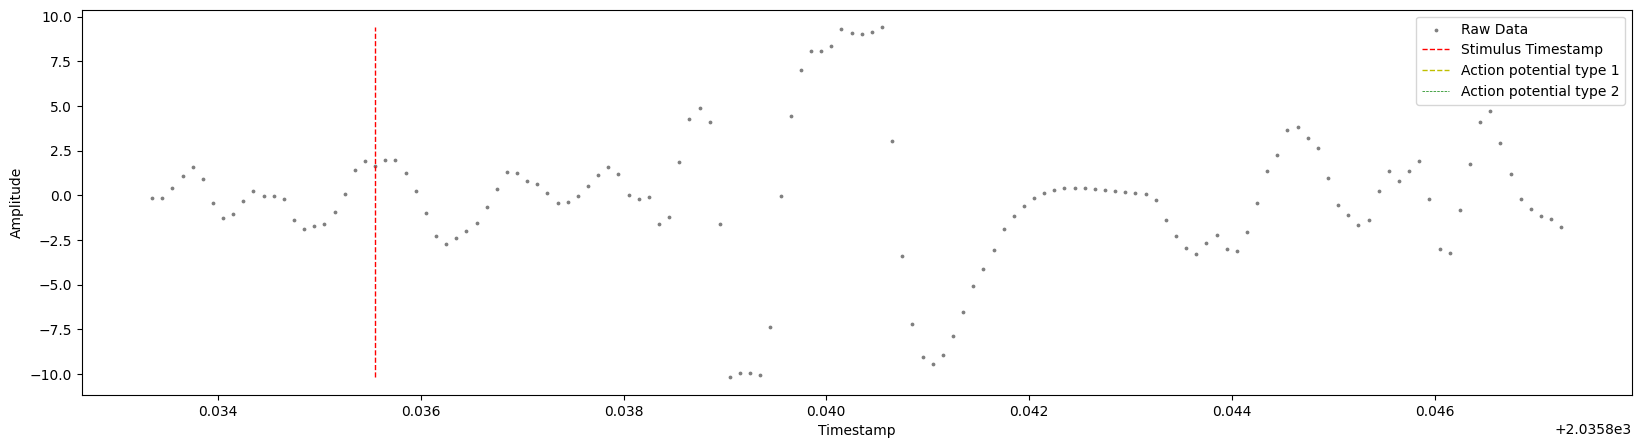

In [59]:
df_first_part = raw_data.iloc[356360:356500]
plot_data(df_first_part)

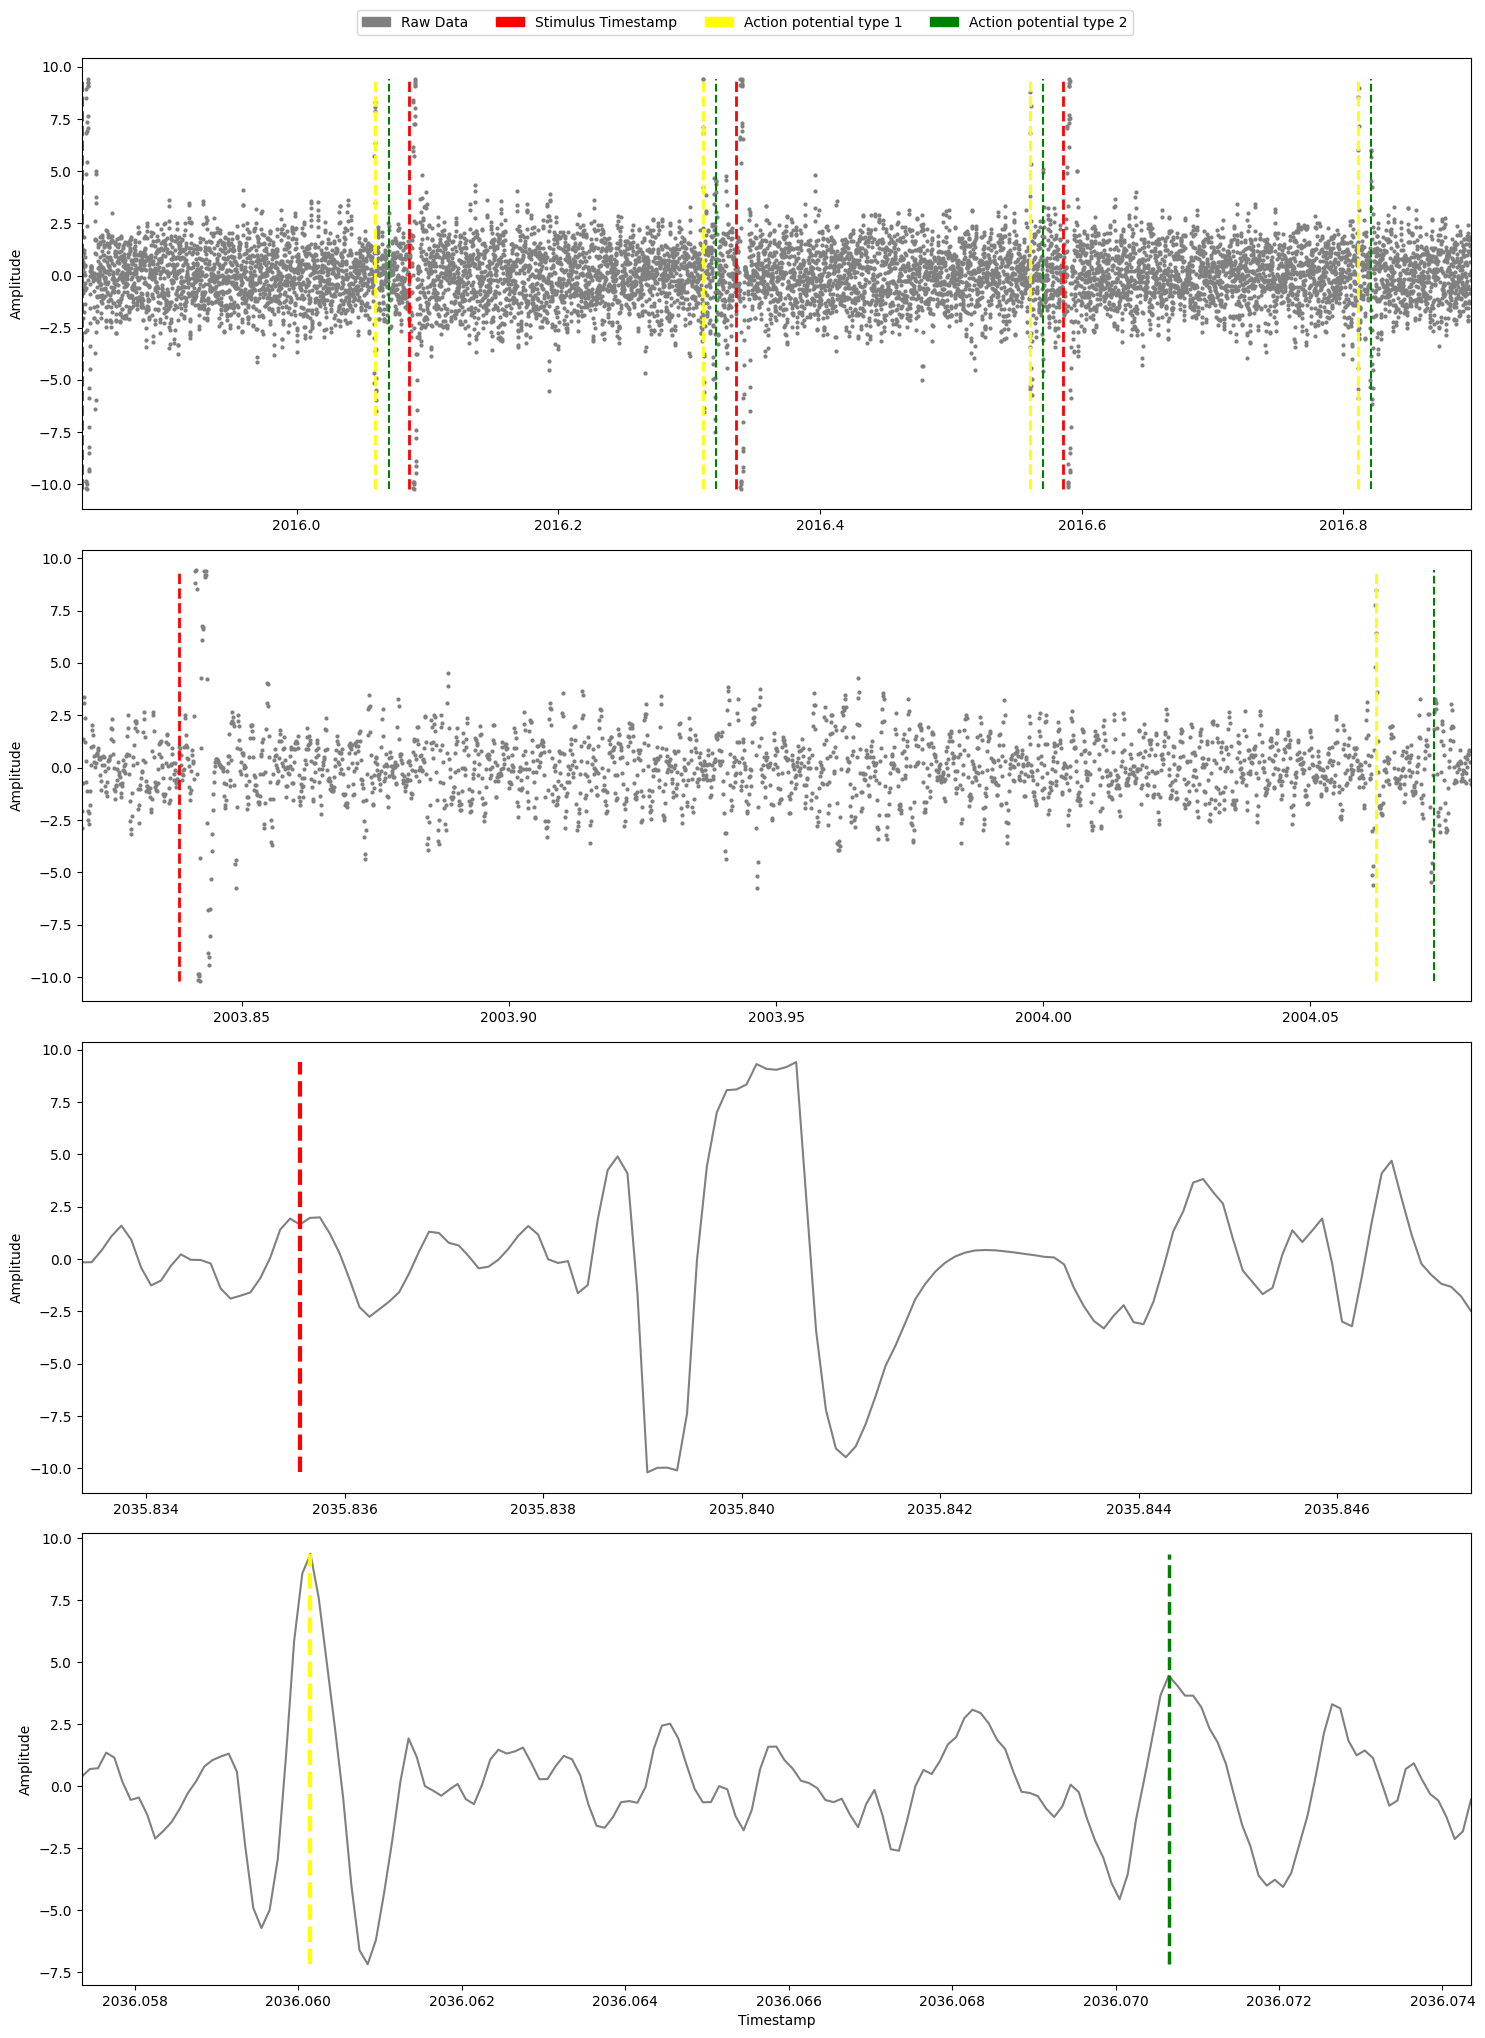

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

def plot_data_multiple_ranges(df, stimulation, ground_truth_spikes, ranges):
    """
    Plot data with multiple subplots, each having its own x-axis scale, and a common legend.

    Parameters:
    - df: DataFrame containing raw data with 'raw_ts' and 'raw_amplitude' columns.
    - stimulation: DataFrame containing 'stimulation_ts'.
    - ground_truth_spikes: DataFrame containing 'spike_ts' and 'track'.
    - ranges: List of (start, end) tuples representing indices to plot.
    """
    num_subplots = len(ranges)
    fig, axes = plt.subplots(num_subplots, 1, figsize=(15, 5 * num_subplots))

    # Prepare legend elements
    legend_elements = [
        mpatches.Patch(color='gray', label='Raw Data'),
        mpatches.Patch(color='red', label='Stimulus Timestamp'),
        mpatches.Patch(color='yellow', label='Action potential type 1'),
        mpatches.Patch(color='green', label='Action potential type 2')
    ]

    for i, (start, end) in enumerate(ranges):
        ax = axes[i] if num_subplots > 1 else axes

        # Determine range based on indices
        min_ts = df['raw_ts'].iloc[start]
        max_ts = df['raw_ts'].iloc[end]

        # Filter data for the current range
        df_range = df[(df['raw_ts'] >= min_ts) & (df['raw_ts'] <= max_ts)]
        df_stim_range = stimulation[(stimulation['stimulation_ts'] >= min_ts) & (stimulation['stimulation_ts'] <= max_ts)]
        df_gt_range = ground_truth_spikes[(ground_truth_spikes['spike_ts'] >= min_ts) & (ground_truth_spikes['spike_ts'] <= max_ts)]

        df_value1 = df_gt_range[df_gt_range['track'] == 'Track3']
        df_value2 = df_gt_range[df_gt_range['track'] == 'Track4']

        # Plot raw data
        if i < 2:  # First two plots as scatter plots
            ax.scatter(df_range['raw_ts'], df_range['raw_amplitude'], color='gray', s=4)
            #ax.plot(df_range['raw_ts'], df_range['raw_amplitude'], color='gray', linewidth=0.5)
            # Plot vertical lines for stimulus and action potentials
            ax.vlines(df_stim_range['stimulation_ts'], 
                    ymin=df_range['raw_amplitude'].min(), 
                    ymax=df_range['raw_amplitude'].max(), 
                    color='red', linestyle='--', linewidth=2)
            
            ax.vlines(df_value1['spike_ts'], 
                    ymin=df_range['raw_amplitude'].min(), 
                    ymax=df_range['raw_amplitude'].max(), 
                    color='yellow', linestyle='--', linewidth=2)
            
            ax.vlines(df_value2['spike_ts'], 
                    ymin=df_range['raw_amplitude'].min(), 
                    ymax=df_range['raw_amplitude'].max(), 
                    color='green', linestyle='--', linewidth=1.5)
        else:  # Last plots as line plots
            ax.plot(df_range['raw_ts'], df_range['raw_amplitude'], color='gray', linewidth=1.5)
            # Plot vertical lines for stimulus and action potentials
            ax.vlines(df_stim_range['stimulation_ts'], 
                    ymin=df_range['raw_amplitude'].min(), 
                    ymax=df_range['raw_amplitude'].max(), 
                    color='red', linestyle='--', linewidth=3)
            
            ax.vlines(df_value1['spike_ts'], 
                    ymin=df_range['raw_amplitude'].min(), 
                    ymax=df_range['raw_amplitude'].max(), 
                    color='yellow', linestyle='--', linewidth=3)
            
            ax.vlines(df_value2['spike_ts'], 
                    ymin=df_range['raw_amplitude'].min(), 
                    ymax=df_range['raw_amplitude'].max(), 
                    color='green', linestyle='--', linewidth=2.5)

        
        ax.set_xlim(min_ts, max_ts)
        ax.set_ylabel('Amplitude')
        ax.ticklabel_format(useOffset=False)
        if i == num_subplots - 1:
            ax.set_xlabel('Timestamp')

    fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    plt.show()


ranges = [
    (157382, 168000),
    (38200, 40800),
    # (78280, 80800),
    (356360, 356500),
    (358600, 358770)
]

plot_data_multiple_ranges(raw_data, stimulation, ground_truth_spikes, ranges)
